# Time series clustering exercise

In [416]:
from __future__ import print_function, division
import pandas as pd
import os
import requests
import shapely
import json
import urllib
import zipfile 
from fiona.crs import from_epsg
import scipy as sp
from scipy import stats
from geopandas import GeoDataFrame


import geopandas as gpd
import pylab as pl
import io
import pylab as pl

from scipy import stats
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Downloada the Data

In [334]:
#Check the PUIdata 
print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/yc3763/PUIdata


In [335]:
# download the NYC Zipcode shapefile 
#! curl -O https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
#! unzip YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20\?filename\=ZIP_CODE_040114.zip -d $PUIDATA

In [336]:
zips = GeoDataFrame.from_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")

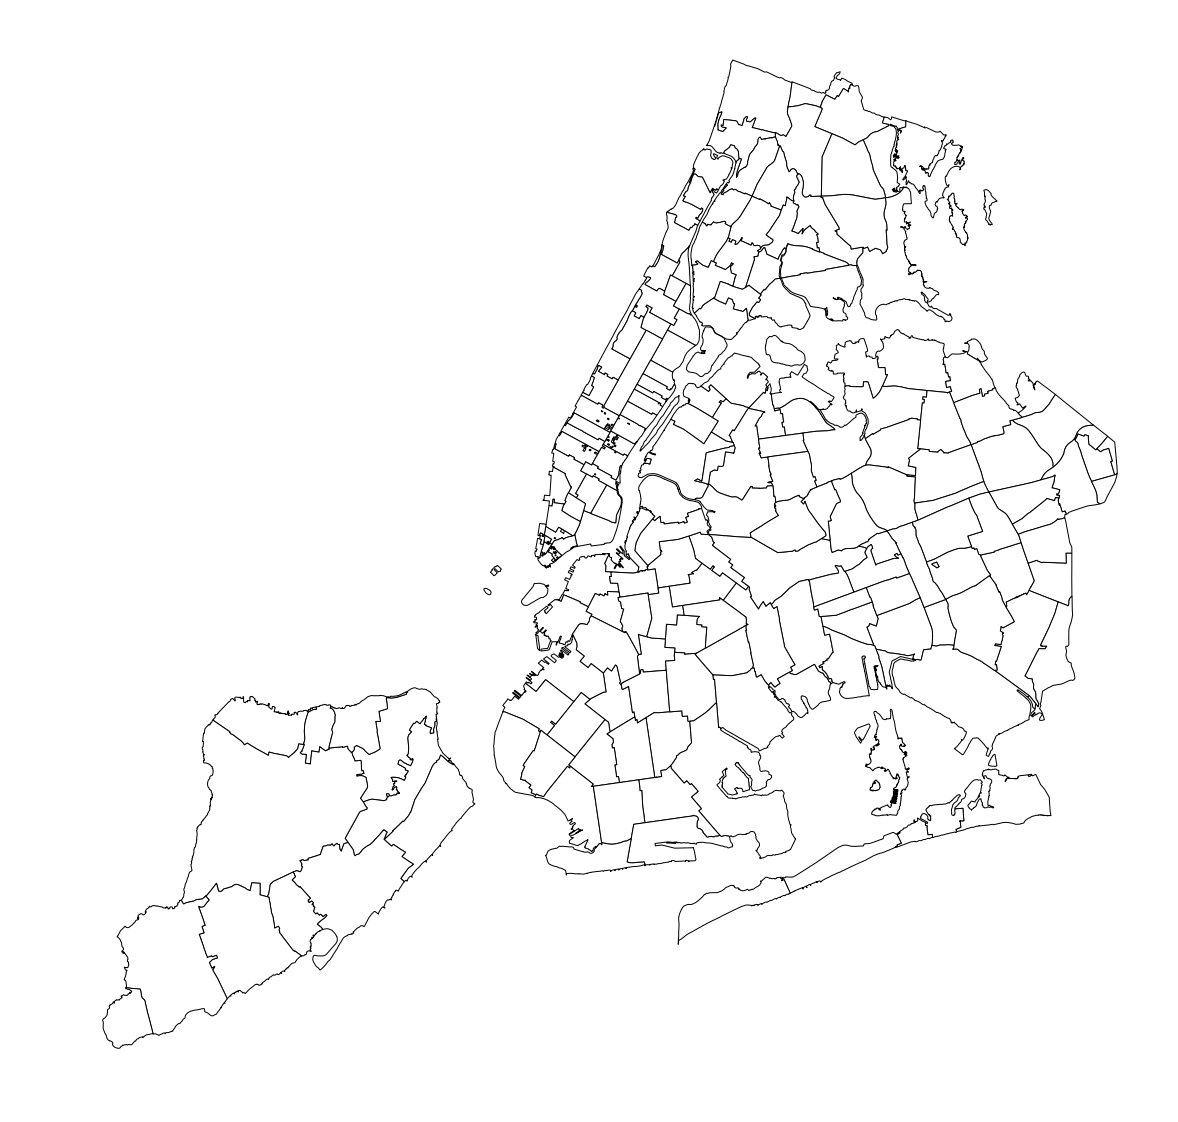

In [337]:
fig = pl.figure(figsize = (20,20))
ax = fig.add_subplot(111)
zips.plot(ax=ax, color='white', edgecolor='black', lw=1)
ax.axis('off');

### Figure 1: NYC Zipe code plot

In [338]:
zips.shape

(263, 13)

## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

In [339]:
data_years = ['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
               '10', '11', '12', '13', '14']

for i in range(len(data_years)):
    filename = 'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp' + str(data_years[i]) + 'totals.zip?raw=true'
    urllib.request.urlretrieve(filename, 'zipped.gz')
    os.system('unzip zipped.gz')
    os.system('mv ' + 'zbp' + str(data_years[i]) + 'totals.txt $PUIDATA')

In [340]:
merged_df = pd.read_csv(os.getenv("PUIDATA") + '/zbp94totals.txt', dtype={'zip': str})
merged_df.columns = [x.lower() for x in merged_df.columns]
merged_df.head()

,zip,name,empflag,emp,qp1,ap,est
0,01001,"Agawam, MA",NaN,6198,33601,155158,439
1,01002,"Amherst, MA",NaN,6073,28924,127367,450
2,01003,"Amherst, MA",NaN,68,367,1604,10
3,01004,"Amherst, MA",NaN,210,844,4302,47
4,01005,"Barre, MA",NaN,678,3010,13521,92


In [341]:
merged_df = merged_df[['zip', 'est']]
merged_df.rename(columns = {'est': 'est94'}, inplace = True)
merged_df.head()

,zip,est94
0,01001,439
1,01002,450
2,01003,10
3,01004,47
4,01005,92


In [342]:
# Combine the data from 1994 to 2014
for i in range(len(data_years)-1):
    df = pd.read_csv(os.getenv("PUIDATA") + '/zbp' + str(data_years[i+1]) + 'totals.txt', dtype={'zip': str, 'ZIP': str})
    df.columns = [x.lower() for x in df.columns]
    df = df[['zip', 'est']]
    df.rename(columns = {'est' : 'est' + str(data_years[i+1])}, inplace = True)
    merged_df = merged_df.merge(df, how = 'inner', left_on = 'zip', right_on = 'zip')

In [343]:
merged_df.head()

,zip,est94,est95,est96,est97,est98,est99,est00,est01,est02,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,01001,439,439,433,457,444,469,493,490,490,...,509,509,503,477,458,448,436,453,439,458
1,01002,450,467,487,500,490,558,563,587,566,...,589,582,596,584,571,570,558,572,572,560
2,01003,10,10,13,15,14,13,13,13,15,...,12,12,16,17,16,16,16,15,15,18
3,01004,47,48,47,41,31,35,48,37,23,...,31,30,20,18,18,21,19,16,16,13
4,01005,92,95,101,104,95,82,86,90,94,...,94,98,106,97,87,96,91,94,97,97


# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [344]:
import geopandas as gp
nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
#nyczipsshp.plot()
#nyczipsshp.drop_duplicates("ZIPCODE").plot()
#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [345]:
# Zipcode shapefile 
zips.shape

(263, 13)

In [346]:
zips.columns
NYCzip = zips.drop([ 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN'],axis=1)

In [347]:
NYCzip.shape

(263, 2)

In [348]:
NYCzip.rename(columns = {'ZIPCODE': 'zip'}, inplace = True)

In [350]:
NYCzip.head()

,zip,geometry
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [351]:
 #Merge two dataset 

In [352]:
NYCZIP = NYCzip.merge(merged_df, how = 'left')
NYCZIP



,zip,geometry,est94,est95,est96,est97,est98,est99,est00,est01,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0
5,11226,"POLYGON ((994821.4729396403 177865.7178093046,...",879.0,882.0,885.0,904.0,942.0,923.0,917.0,884.0,...,1049.0,1015.0,1049.0,1083.0,1097.0,1127.0,1169.0,1229.0,1256.0,1283.0
6,11219,"POLYGON ((987286.3515269756 173946.4621963799,...",1650.0,1708.0,1768.0,1863.0,1928.0,1997.0,2079.0,2153.0,...,2343.0,2351.0,2391.0,2396.0,2487.0,2581.0,2647.0,2696.0,2777.0,2882.0
7,11210,"POLYGON ((995796.0097044706 171110.0666224658,...",763.0,783.0,779.0,806.0,815.0,776.0,792.0,816.0,...,875.0,893.0,887.0,906.0,919.0,990.0,1030.0,1006.0,1003.0,1026.0
8,11230,"POLYGON ((994099.2959063053 171240.7064530551,...",1411.0,1465.0,1537.0,1563.0,1605.0,1670.0,1753.0,1807.0,...,1930.0,1934.0,1934.0,1945.0,1984.0,2026.0,2062.0,1999.0,2095.0,2150.0
9,11204,"POLYGON ((989500.1699339747 170730.1687602103,...",1287.0,1297.0,1334.0,1374.0,1444.0,1481.0,1656.0,1686.0,...,1778.0,1806.0,1858.0,1826.0,1817.0,1902.0,1960.0,2024.0,2108.0,2205.0


In [353]:
NYCZIP = NYCZIP.dropna()
NYCZIP.shape

(243, 23)

In [354]:
csb = NYCZIP.drop(['zip', 'geometry'],axis =1)

In [355]:
cleancsb = csb.dropna()
cleancsb.shape

(243, 21)

In [356]:
#then the standardization will look like:
vals = ((cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1)).T
vals.head()

,est94,est95,est96,est97,est98,est99,est00,est01,est02,est03,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,0.087870,-0.117160,...,0.292900,0.190385,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853
1,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,-0.150580,0.060232,...,-0.058923,0.023569,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875
2,-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,-0.212389,-0.164301,...,-0.092169,-0.296543,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464
3,-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,-0.184704,-0.089324,...,-0.057531,0.027251,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007
4,-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,-0.357567,-0.270200,...,0.120649,0.116050,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331


In [357]:
print(vals.mean(axis=1).head())
print(vals.mean(axis=1).shape)

0   -3.595008e-16
1   -1.268826e-16
2    4.652363e-16
3   -1.903239e-16
4   -2.537653e-16
dtype: float64
(243,)


In [358]:
print(vals.std(axis=1).head())

print(vals.std(axis=1).shape)

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64
(243,)


# 3. Cluster
### K = 5

In [359]:
#cluster with kmeans
nc = 5 
km = KMeans(n_clusters=nc, random_state=444).fit(vals)

In [360]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km5 = km.labels_
print(km5)

[0 0 0 0 0 0 0 0 3 0 0 0 3 0 0 0 4 0 0 0 0 0 3 0 3 0 0 4 4 3 0 0 0 3 0 0 0
 0 0 0 3 0 0 0 0 0 3 0 0 0 3 3 0 0 0 3 3 3 3 1 3 0 3 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 4 2 1 3 3 4 0 4 0 3 0 0 3 0 3 3 2 4 0 0 1 0 1 3 3 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 4 0 3 2 0 0 0 0 0 0 3 3 3 0 3 3 0 0 0 3 0 0 0 0 0 3 0
 0 0 3 0 3 3 3 0 3 0 2 0 0 0 0 3 0 3 0 3 0 3 0 3 0 3 4 0 0 0 0 0 0 0 3 1 1
 2 0 1 0 1 0 2 3 0 0 4 1 2 2 1 2 4 3 1 2 1 0 1 1 0 2 2 0 1 2 4 1 1 2 2 2 1
 1 2 2 3 2 4 2 1 1 1 2 3 0 3 0 4 4 0 0 4 3]


In [361]:
km.labels_.shape

(243,)

### Map the clusters 

In [362]:
kmlabel = pd.DataFrame (km.labels_)
kmlabel.head()

,0
0,0
1,0
2,0
3,0
4,0


In [363]:
nyplot = NYCZIP[['zip','geometry']]

In [364]:
nyplot.head()

,zip,geometry
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [365]:

nykmeans = nyplot.merge(kmlabel, left_index=True, right_index=True)
nykmeans.rename(columns = {0: 'km5'},inplace = True)
nykmeans.head()

,zip,geometry,km5
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",0
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",0
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",0
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",0
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",0


In [367]:
nykmeans.shape

(231, 3)

Text(0.5,1,'NYC Clustering MAP (by K-means (k=5))')

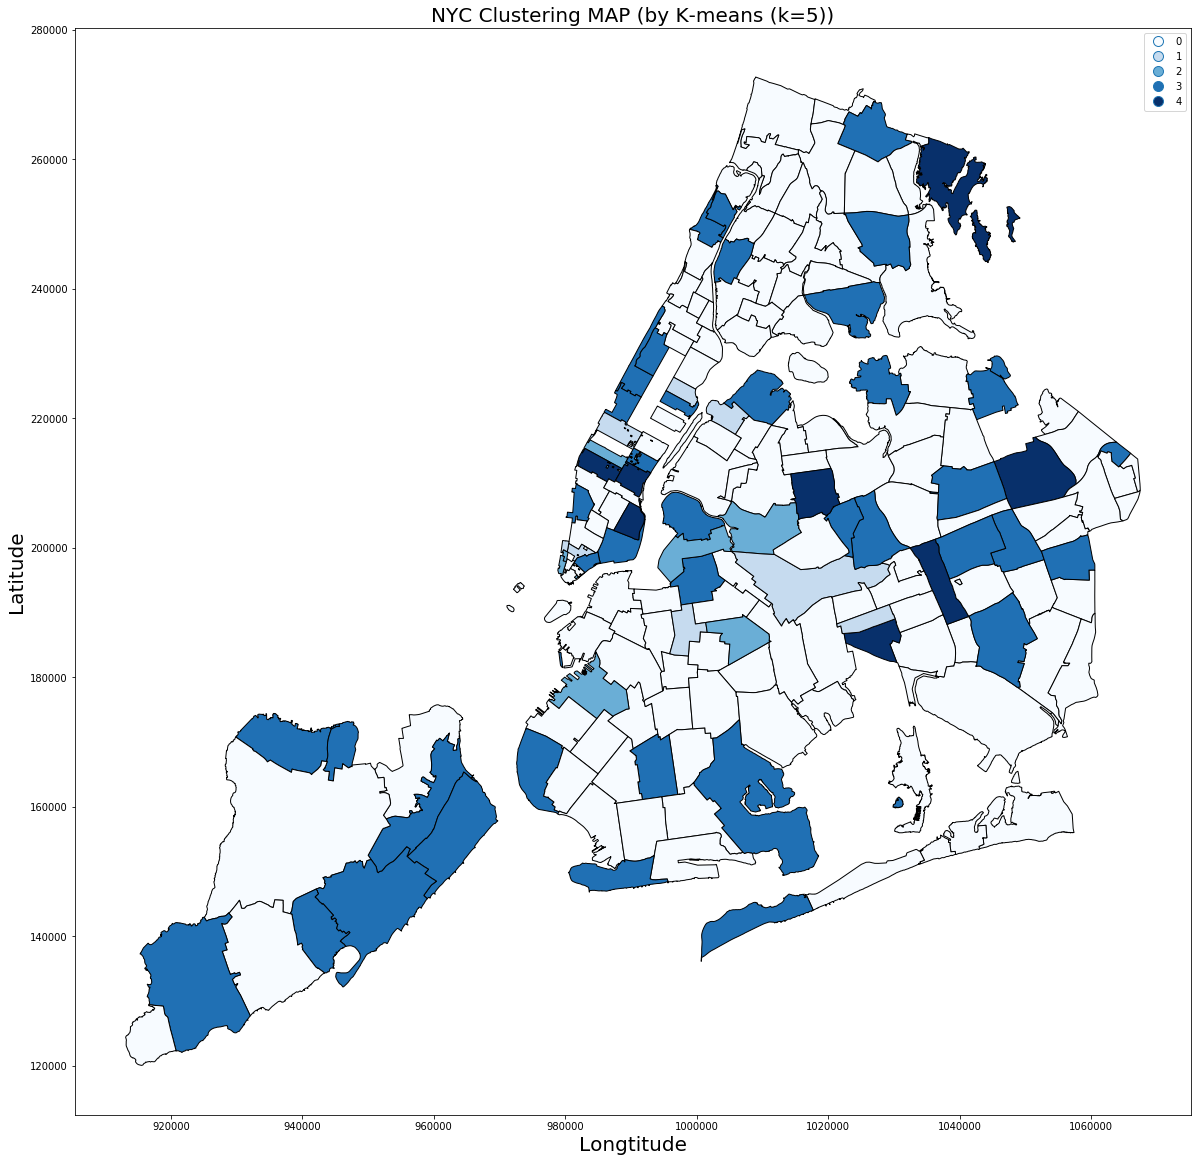

In [330]:
## Map the cluster 
f = plt.figure(figsize=(20, 20))
ax = f.add_subplot(111)
nykmeans.plot(column= 'km5', categorical=True, legend=True, cmap="Blues", ax=ax, edgecolor="black")
ax.set_xlabel("Longtitude", fontsize=20)
ax.set_ylabel("Latitude", fontsize=20)
ax.set_title("NYC Clustering MAP (by K-means (k=5))", fontsize=20)

In [ ]:
Figure 2: The 

In [385]:
NYCZIP_NA =NYCZIP.dropna()
NYCZIPKM = NYCZIP_NA.drop(['geometry'],axis = 1)
NYCZIPKM.head()

,zip,est94,est95,est96,est97,est98,est99,est00,est01,est02,...,est06,est07,est08,est09,est10,est11,est12,est13,est14,km
0,11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,...,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0,0.0
1,11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,...,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0,0.0
2,11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,...,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0,0.0
3,11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,...,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0,0.0
4,11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,...,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0,0.0


In [393]:
NYCZIPKM.iloc[:, 1:-1] = ((NYCZIPKM.iloc[:, 1:-1].T - NYCZIPKM.iloc[:, 1:-1].mean(1)) / 
                          NYCZIPKM.iloc[:, 1:-1].std(1)).T
NYCZIPKM.head()

,zip,est94,est95,est96,est97,est98,est99,est00,est01,est02,...,est06,est07,est08,est09,est10,est11,est12,est13,est14,km
0,11436,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,0.087870,...,0.190385,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853,0.0
1,11213,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,-0.150580,...,0.023569,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875,0.0
2,11212,-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,-0.212389,...,-0.296543,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464,0.0
3,11225,-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,-0.184704,...,0.027251,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007,0.0
4,11218,-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,-0.357567,...,0.116050,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331,0.0


In [399]:
type(NYCZIPKM)

geopandas.geodataframe.GeoDataFrame

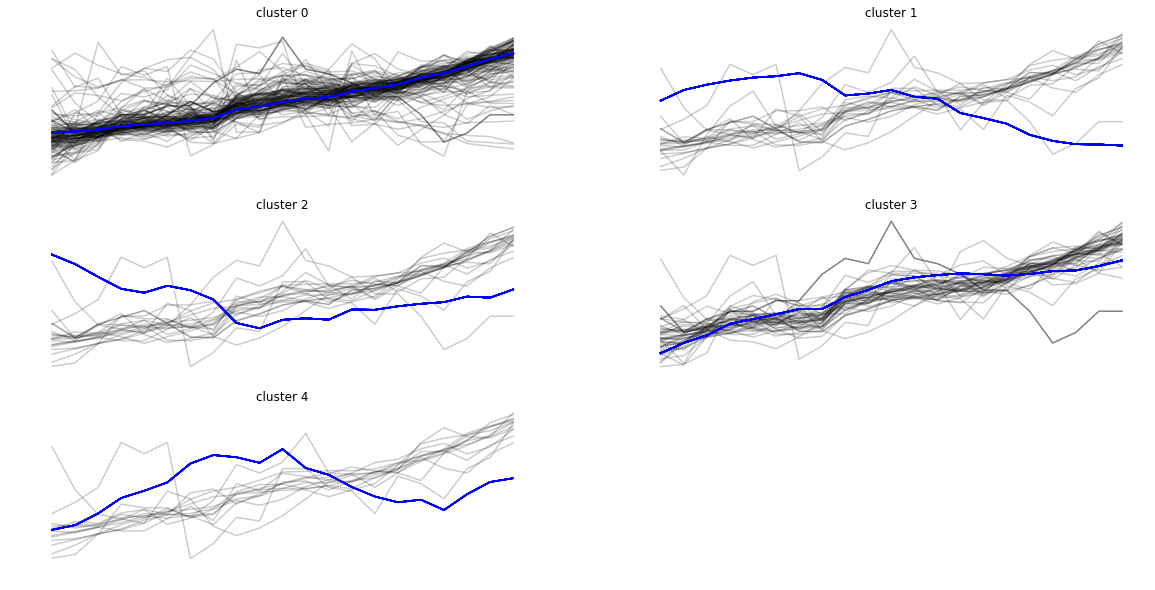

In [414]:

fig = pl.figure(figsize=(20,10))
for i in range(5):
    plotts = (nykmeans[nykmeans['km5'] == i]).reset_index()
    ax = fig.add_subplot(3,2,i+1)
    ax.set_title('cluster %s'%i)
    for j in list(plotts.index):
        ax.plot(range(21), vals.iloc[j], 'k-', alpha=0.2)
        pl.plot(range(21), km.cluster_centers_[i], 'b-', label='center of cluster %s'%i)
        ax.set_axis_off()

### Figure 3: Time seriers in each plot 

# If you want to use agglomerative clustering

In [419]:
agc = AgglomerativeClustering(n_clusters=nc, linkage='average').fit(vals)
labelsag = agc.labels_
centroidsag = np.zeros((nc, vals.shape[1]))
labelsag


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 3, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 4, 0, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 3,
       3, 4, 2, 3, 2, 3, 2, 3, 2, 2, 2, 0, 3, 4, 1, 3, 3, 0, 2, 3, 4, 3, 2,
       3, 3, 2, 2, 4, 2, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 2, 2, 4, 0,
       0, 0, 3, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2])

In [421]:
gm_lable = pd.DataFrame (labelsag)
gm_lable.head()

,0
0,2
1,2
2,2
3,2
4,2


In [424]:
nygm = nyplot.merge(gm_lable, left_index=True, right_index=True)

In [425]:
nygm.rename(columns = {0: 'gm'},inplace = True)
nygm.head()

,zip,geometry,gm
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",2
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",2
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",2
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",2
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",2


Text(0.5,1,'NYC Clustering MAP (by K-means (k=5))')

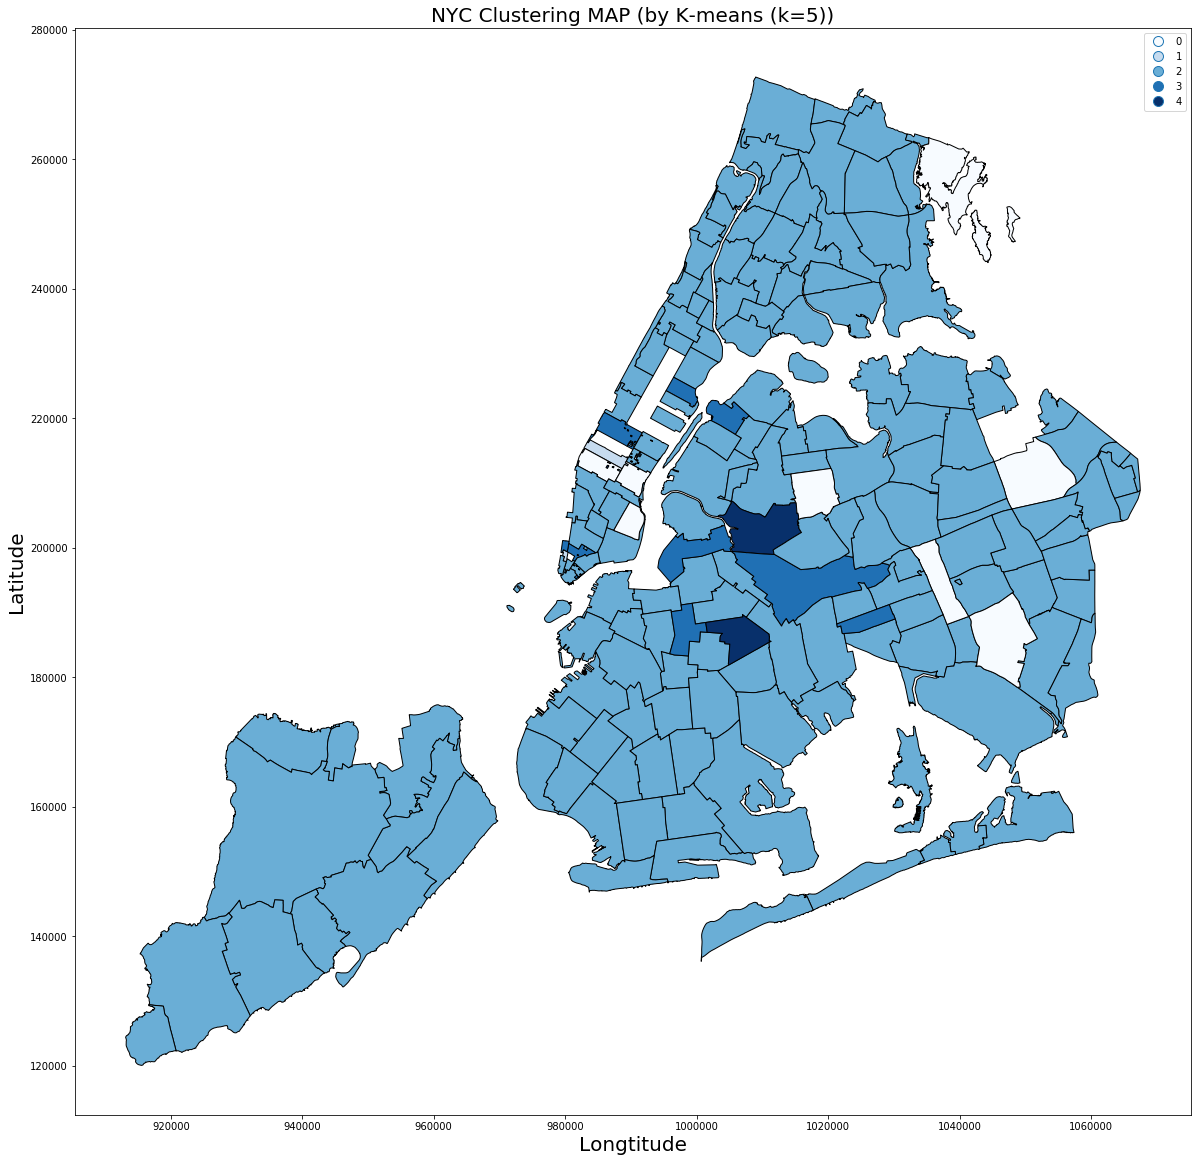

In [426]:
f = plt.figure(figsize=(20, 20))
ax = f.add_subplot(111)
nygm.plot(column= 'gm', categorical=True, legend=True, cmap="Blues", ax=ax, edgecolor="black")
ax.set_xlabel("Longtitude", fontsize=20)
ax.set_ylabel("Latitude", fontsize=20)
ax.set_title("NYC Clustering MAP (by K-means (k=5))", fontsize=20)

### And if you use hierarchical clustering in scipy you can make a dandrogram it may look like this:

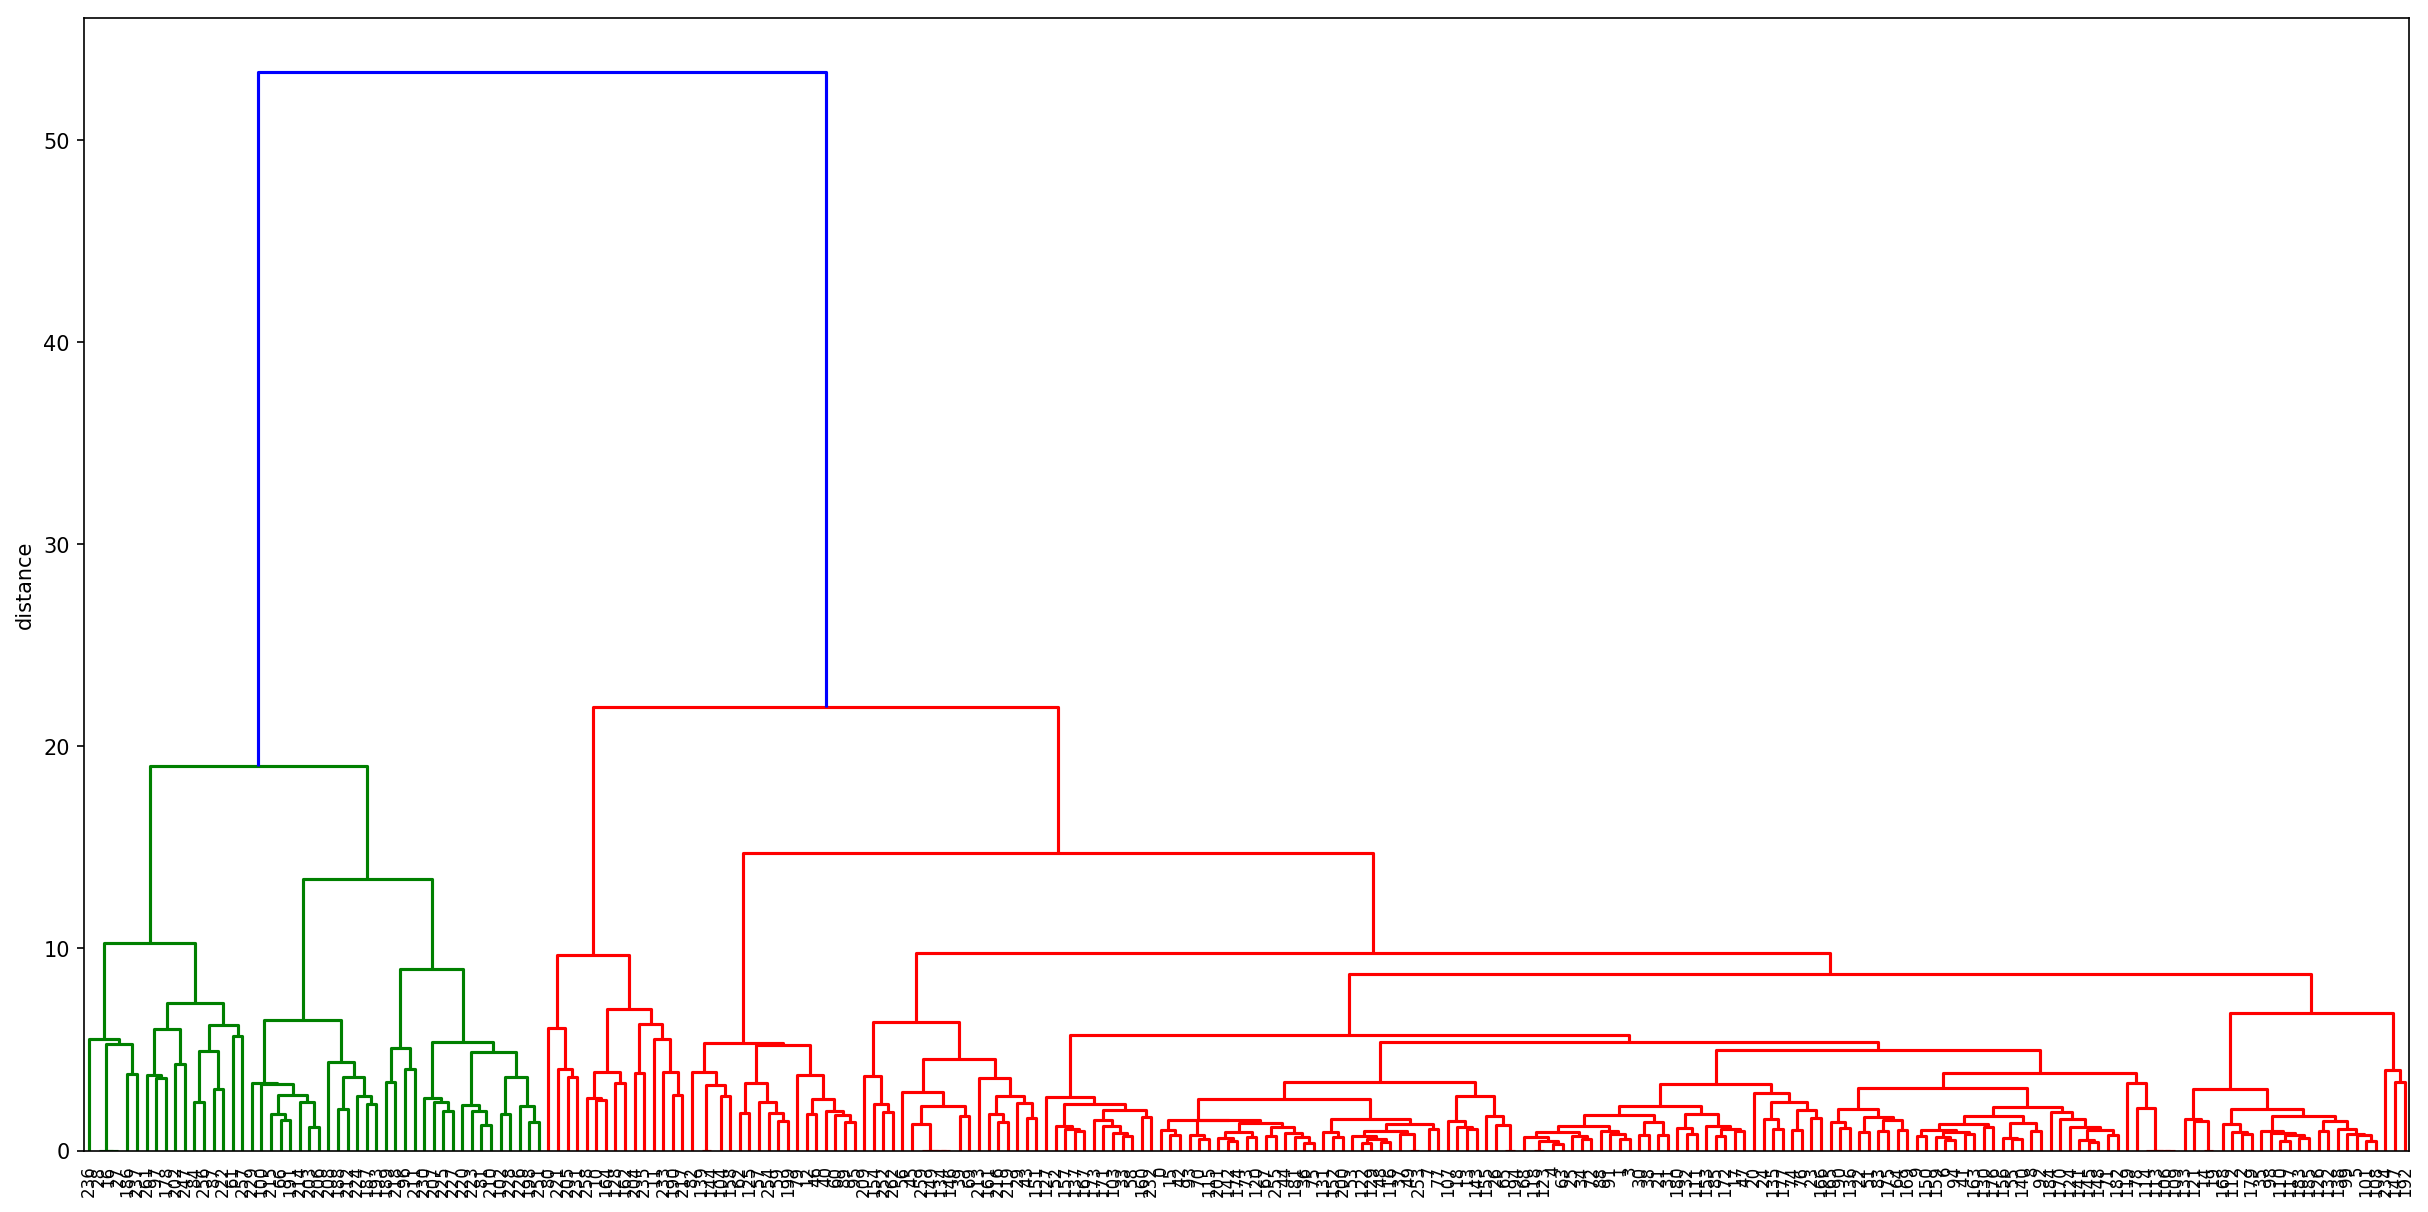

In [428]:
import scipy.cluster as scp
fig = pl.figure(figsize=(20,10), dpi=150)
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'),
                               labels = vals.index,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.)  # font size for the x axis labels)


In [429]:
!pwd

/nfshome/yc3763/PUI2018/PUI2018_yc3763/HW12_yc3763
